In [2]:
import numpy as np
from scipy.stats import uniform
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Define concentration ranges for each substance
concentration_ranges = {
    'decanoic acid': (0, 5.),
    'decanoate': (0, 5.),
    'decylamine': (0, 5.),
    'decyl trimethylamine': (0, 5.),
    'decylsulfate': (0, 5.),
    'decanol': (0, 1.5),
    'monocaprin': (0, 1.)
}

# Additional constraints
total_concentration_limit = 50
decanoic_decanoate_limit = 25

# Generate compositions for samples
num_samples = 96
num_substances = 7

# Initialize an empty list to store valid samples
valid_samples = []

# Iterate until we have 48 valid samples
while len(valid_samples) < num_samples:
    # Generate concentrations for each substance
    concentrations = {substance: np.random.uniform(min_conc, max_conc) 
                      for substance, (min_conc, max_conc) in concentration_ranges.items()}
    
    # Calculate total concentration and sum of decanoic acid and decanoate
    total_concentration = sum(concentrations.values())
    decanoic_decanoate_sum = concentrations['decanoic acid'] + concentrations['decanoate']
    
    # Check if the constraints are satisfied
    if total_concentration <= total_concentration_limit and decanoic_decanoate_sum <= decanoic_decanoate_limit:
        # Append the concentrations to the list of valid samples
        valid_samples.append(concentrations)

# Convert the list of valid samples to a pandas DataFrame
concentrations_df = pd.DataFrame(valid_samples)

# Rename columns
concentrations_df.columns = ['decanoic acid (mM)', 'decanoate (mM)', 'decylamine (mM)', 
              'decyl trimethylamine (mM)', 'decylsulfate (mM)', 
              'decanol (mM)', 'monocaprin (mM)']

concentrations_df

,decanoic acid (mM),decanoate (mM),decylamine (mM),decyl trimethylamine (mM),decylsulfate (mM),decanol (mM),monocaprin (mM)
0,0.850468,1.592315,2.432763,3.728467,4.337531,0.555865,0.786828
1,3.413249,0.903173,0.191721,1.868612,2.380149,0.230680,0.112696
2,2.193435,1.023726,2.638847,4.971697,4.246179,0.172725,0.224840
3,3.622401,4.964482,0.466007,0.074156,3.362531,0.799990,0.120320
4,2.222966,3.232187,4.353717,1.429644,1.753507,1.119350,0.349945
...,...,...,...,...,...,...,...
91,2.541373,4.430402,0.737003,0.587376,2.393014,0.725345,0.099858
92,0.075674,0.668966,2.999802,3.914720,2.422422,0.599045,0.101580
93,1.452742,1.719083,3.298524,0.272543,0.106067,0.050467,0.730248
94,4.123858,2.123420,2.670436,4.659496,1.107112,0.809824,0.582170


In [9]:
# Identify the unique solutes in the dataframe
unique_solutes = set(col.split(' (')[0] for col in dispense_df.columns)
unique_solutes

{'decanoate',
 'decanoic acid',
 'decanol',
 'decyl trimethylamine',
 'decylamine',
 'decylsulfate',
 'monocaprin'}

In [10]:
stocks = [[50, 10, 2], [50, 10, 2], [50, 10, 2], [50, 10, 2], [50, 10, 2], [15, 3], [10, 2]]
valid_dispense_volumes = [[(4, 20), (4, 20), (0, 20)], [(4, 20), (4, 20), (0, 20)], [(4, 20), (4, 20), (0, 20)],
                          [(4, 20), (4, 20), (0, 20)], [(4, 20), (4, 20), (0, 20)], [(4, 20), (0, 20)], [(4, 20), (0, 20)]]

# Total volume
total_volume = 200

# Initialize empty DataFrame to store dispense volumes
column_names = []
for i, (col, stock) in enumerate(zip(concentrations_df.columns, stocks), start=1):
    for j, concentration in enumerate(stock, start=1):
        column_names.append(f'{col} ({concentration} mM)')

dispense_df = pd.DataFrame(columns=column_names)

# Iterate through each row of concentrations dataframe
for index, row in concentrations_df.iterrows():
    dispense_volumes = []
    
    # Calculate required volume for each stock solution
    for i, (conc, stock, valid_vol) in enumerate(zip(row, stocks, valid_dispense_volumes), start=1):
        total_mass = conc * total_volume
        volumes = [total_mass / s for s in stock]
        
        # Initialize a list to store volumes for this stock solution
        stock_dispense_volumes = []
        
        # Flag to track if a valid volume has been encountered
        valid_volume_found = False
        
        # Check all possible volumes within the valid dispense volume range
        for volume, vol_range in zip(volumes, valid_vol):
            if not valid_volume_found and vol_range[0] <= volume <= vol_range[1]:
                stock_dispense_volumes.append(volume)
                # Set the flag to True to indicate a valid volume has been found
                valid_volume_found = True
            else:
                stock_dispense_volumes.append(0)
        
        # Append the volumes for this stock solution to dispense_volumes
        dispense_volumes.extend(stock_dispense_volumes)
        
    # Append dispense volumes for this row to the dataframe
    dispense_df.loc[index] = dispense_volumes
    # Round all numbers in the DataFrame to one decimal place
    dispense_df = dispense_df.round(1)
    # Apply custom function to each element of the DataFrame
    # dispense_df = dispense_df.applymap(discretize)

# Iterate over the rows and remove those where all columns for the same solute are zero
rows_to_remove = []
for index, row in dispense_df.iterrows():
    all_zero = True
    for solute in unique_solutes:
        solute_cols = [col for col in dispense_df.columns if solute in col]
        if all(row[col] == 0 for col in solute_cols):
            all_zero = all_zero and True
            rows_to_remove.append(index)
        else:
            all_zero = False

# Remove the identified rows
dispense_df = dispense_df.drop(rows_to_remove)
df_length = len(dispense_df)
print(df_length)

96


In [11]:
dispense_df

,decanoic acid (mM) (50 mM),decanoic acid (mM) (10 mM),decanoic acid (mM) (2 mM),decanoate (mM) (50 mM),decanoate (mM) (10 mM),decanoate (mM) (2 mM),decylamine (mM) (50 mM),decylamine (mM) (10 mM),decylamine (mM) (2 mM),decyl trimethylamine (mM) (50 mM),decyl trimethylamine (mM) (10 mM),decyl trimethylamine (mM) (2 mM),decylsulfate (mM) (50 mM),decylsulfate (mM) (10 mM),decylsulfate (mM) (2 mM),decanol (mM) (15 mM),decanol (mM) (3 mM),monocaprin (mM) (10 mM),monocaprin (mM) (2 mM)
0,0.0,17.0,0.0,6.4,0.0,0.0,9.7,0.0,0.0,14.9,0.0,0.0,17.4,0.0,0.0,7.4,0.0,15.7,0.0
1,13.7,0.0,0.0,0.0,18.1,0.0,0.0,0.0,19.2,7.5,0.0,0.0,9.5,0.0,0.0,0.0,15.4,0.0,11.3
2,8.8,0.0,0.0,4.1,0.0,0.0,10.6,0.0,0.0,19.9,0.0,0.0,17.0,0.0,0.0,0.0,11.5,4.5,0.0
3,14.5,0.0,0.0,19.9,0.0,0.0,0.0,9.3,0.0,0.0,0.0,7.4,13.5,0.0,0.0,10.7,0.0,0.0,12.0
4,8.9,0.0,0.0,12.9,0.0,0.0,17.4,0.0,0.0,5.7,0.0,0.0,7.0,0.0,0.0,14.9,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,10.2,0.0,0.0,17.7,0.0,0.0,0.0,14.7,0.0,0.0,11.7,0.0,9.6,0.0,0.0,9.7,0.0,0.0,10.0
92,0.0,0.0,7.6,0.0,13.4,0.0,12.0,0.0,0.0,15.7,0.0,0.0,9.7,0.0,0.0,8.0,0.0,0.0,10.2
93,5.8,0.0,0.0,6.9,0.0,0.0,13.2,0.0,0.0,0.0,5.5,0.0,0.0,0.0,10.6,0.0,3.4,14.6,0.0
94,16.5,0.0,0.0,8.5,0.0,0.0,10.7,0.0,0.0,18.6,0.0,0.0,4.4,0.0,0.0,10.8,0.0,11.6,0.0


In [12]:
dispense_df_send = dispense_df.iloc[0:48,:]
dispense_df_send.to_csv('dispense_df_20240415.csv', index=False)

In [14]:
dispense_df_send

,decanoic acid (mM) (50 mM),decanoic acid (mM) (10 mM),decanoic acid (mM) (2 mM),decanoate (mM) (50 mM),decanoate (mM) (10 mM),decanoate (mM) (2 mM),decylamine (mM) (50 mM),decylamine (mM) (10 mM),decylamine (mM) (2 mM),decyl trimethylamine (mM) (50 mM),decyl trimethylamine (mM) (10 mM),decyl trimethylamine (mM) (2 mM),decylsulfate (mM) (50 mM),decylsulfate (mM) (10 mM),decylsulfate (mM) (2 mM),decanol (mM) (15 mM),decanol (mM) (3 mM),monocaprin (mM) (10 mM),monocaprin (mM) (2 mM)
0,0.0,17.0,0.0,6.4,0.0,0.0,9.7,0.0,0.0,14.9,0.0,0.0,17.4,0.0,0.0,7.4,0.0,15.7,0.0
1,13.7,0.0,0.0,0.0,18.1,0.0,0.0,0.0,19.2,7.5,0.0,0.0,9.5,0.0,0.0,0.0,15.4,0.0,11.3
2,8.8,0.0,0.0,4.1,0.0,0.0,10.6,0.0,0.0,19.9,0.0,0.0,17.0,0.0,0.0,0.0,11.5,4.5,0.0
3,14.5,0.0,0.0,19.9,0.0,0.0,0.0,9.3,0.0,0.0,0.0,7.4,13.5,0.0,0.0,10.7,0.0,0.0,12.0
4,8.9,0.0,0.0,12.9,0.0,0.0,17.4,0.0,0.0,5.7,0.0,0.0,7.0,0.0,0.0,14.9,0.0,7.0,0.0
5,0.0,8.9,0.0,16.0,0.0,0.0,13.3,0.0,0.0,18.3,0.0,0.0,15.7,0.0,0.0,11.7,0.0,0.0,17.2
6,17.7,0.0,0.0,19.3,0.0,0.0,13.2,0.0,0.0,7.2,0.0,0.0,0.0,16.5,0.0,7.2,0.0,16.9,0.0
7,15.6,0.0,0.0,15.6,0.0,0.0,0.0,15.0,0.0,18.9,0.0,0.0,18.5,0.0,0.0,0.0,19.8,5.3,0.0
8,0.0,16.4,0.0,0.0,6.2,0.0,0.0,11.4,0.0,0.0,0.0,8.5,14.7,0.0,0.0,16.7,0.0,10.4,0.0
9,0.0,8.2,0.0,11.7,0.0,0.0,0.0,18.9,0.0,9.7,0.0,0.0,19.7,0.0,0.0,0.0,9.1,7.5,0.0


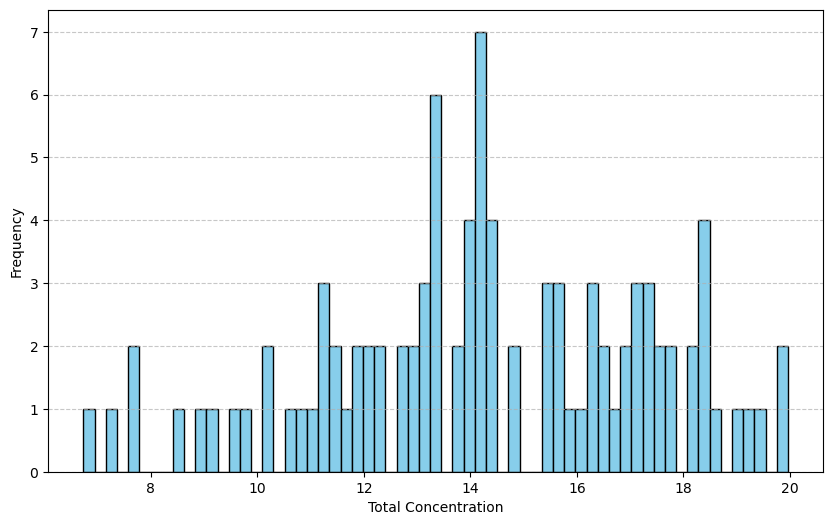

In [13]:
import pandas as pd

total_mass_df = pd.DataFrame()

# Iterate through each row of the DataFrame
for index, row in dispense_df.iterrows():
    total_mass_row = []
    # Iterate through each column
    for column in dispense_df.columns:
        # Extract concentration and volume from column name and cell value
        concentration_str, volume = concentration_str= column.split('(')[2].split(')')[0].split()[0], row[column]
        concentration = float(concentration_str[0])
        # Calculate total mass and append to the list
        total_mass = concentration * volume
        total_mass_row.append(total_mass)
    # Append the total mass row to the DataFrame
    total_mass_df = pd.concat([total_mass_df, pd.Series(total_mass_row)], axis=1)


# Transpose the DataFrame and sum across rows to get the total mass of each row
total_mass_df = total_mass_df.T
total_mass_df['Total Mass'] = total_mass_df.sum(axis=1)
# Divide total mass by 200
total_mass_df['Total Mass'] /= 200

# Plot the distribution of total mass
plt.figure(figsize=(10, 6))
total_mass_df['Total Mass'].plot(kind='hist', bins=63, color='skyblue', edgecolor='black')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
# Repeat the dataframe to have 96 rows
df_repeated = pd.concat([dispense_df_send] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

df_repeated['Destination_Well'] = destination_well

# Rearrange columns
df_repeated = df_repeated[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df_send.columns)]

In [22]:
df_repeated

,Labware_Deck_Slot,Destination_Well,decanoic acid (mM) (50 mM),decanoic acid (mM) (10 mM),decanoic acid (mM) (2 mM),decanoate (mM) (50 mM),decanoate (mM) (10 mM),decanoate (mM) (2 mM),decylamine (mM) (50 mM),decylamine (mM) (10 mM),...,decyl trimethylamine (mM) (50 mM),decyl trimethylamine (mM) (10 mM),decyl trimethylamine (mM) (2 mM),decylsulfate (mM) (50 mM),decylsulfate (mM) (10 mM),decylsulfate (mM) (2 mM),decanol (mM) (15 mM),decanol (mM) (3 mM),monocaprin (mM) (10 mM),monocaprin (mM) (2 mM)
0,1,A1,0.0,17.0,0.0,6.4,0.0,0.0,9.7,0.0,...,14.9,0.0,0.0,17.4,0.0,0.0,7.4,0.0,15.7,0.0
1,1,A2,13.7,0.0,0.0,0.0,18.1,0.0,0.0,0.0,...,7.5,0.0,0.0,9.5,0.0,0.0,0.0,15.4,0.0,11.3
2,1,A3,8.8,0.0,0.0,4.1,0.0,0.0,10.6,0.0,...,19.9,0.0,0.0,17.0,0.0,0.0,0.0,11.5,4.5,0.0
3,1,A4,14.5,0.0,0.0,19.9,0.0,0.0,0.0,9.3,...,0.0,0.0,7.4,13.5,0.0,0.0,10.7,0.0,0.0,12.0
4,1,A5,8.9,0.0,0.0,12.9,0.0,0.0,17.4,0.0,...,5.7,0.0,0.0,7.0,0.0,0.0,14.9,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2,H8,15.6,0.0,0.0,17.9,0.0,0.0,6.1,0.0,...,4.5,0.0,0.0,4.6,0.0,0.0,7.7,0.0,11.7,0.0
92,2,H9,5.1,0.0,0.0,0.0,15.6,0.0,18.6,0.0,...,18.7,0.0,0.0,0.0,4.8,0.0,15.4,0.0,11.2,0.0
93,2,H10,8.9,0.0,0.0,18.1,0.0,0.0,17.2,0.0,...,10.4,0.0,0.0,0.0,15.0,0.0,16.2,0.0,0.0,13.4
94,2,H11,8.4,0.0,0.0,5.4,0.0,0.0,0.0,19.9,...,17.6,0.0,0.0,6.5,0.0,0.0,17.6,0.0,19.6,0.0


In [24]:
# Save to Excel with two sheets
with pd.ExcelWriter('dispense_df_20240416.xlsx') as writer:
    # Write df_repeated to sheet Plate1
    df_repeated.to_excel(writer, sheet_name='Plate1', index=False)
    
    # Write df_repeated to sheet Plate2
    df_repeated.to_excel(writer, sheet_name='Plate2', index=False)